In [3]:
pip install numpy pandas scikit-learn flask joblib


^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

# Load dataset
df = pd.read_csv(r"C:\Users\Asus\Desktop\project_juit\enhanced_crop_dataset.csv")

# Features and label encoding
condition_features = ['Temperature', 'Rainfall', 'Humidity', 'Soil_pH', 'Nitrogen', 'Phosphorus', 'Potassium']
full_features = condition_features + ['Crop']

label_encoder = LabelEncoder()
df['Crop'] = label_encoder.fit_transform(df['Crop'])

# Prepare data for yield prediction (crop-specific)
df_with_yield = df.dropna(subset=['Yield'])

X = df_with_yield[full_features]
y = df_with_yield['Yield']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (excluding encoded crop for now)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[condition_features])
X_test_scaled = scaler.transform(X_test[condition_features])

# Combine scaled features with crop column for training
X_train_final = np.hstack([X_train_scaled, X_train[['Crop']].values])
X_test_final = np.hstack([X_test_scaled, X_test[['Crop']].values])

# Train with GridSearchCV
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
grid_search.fit(X_train_final, y_train)

best_model = grid_search.best_estimator_

# Save the model and scalers
joblib.dump(best_model, 'best_yield_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Evaluate
y_pred = best_model.predict(X_test_final)
mae = mean_absolute_error(y_test, y_pred)
print(f"✅ Yield Prediction Model - MAE: {mae:.2f} tons/ha")

# Crop recommendation logic (uses same scaler)
def recommend_best_crop(input_features):
    all_crops = df['Crop'].unique()
    crop_predictions = []

    for crop in all_crops:
        input_df = pd.DataFrame([input_features], columns=condition_features)
        input_scaled = scaler.transform(input_df)
        combined_input = np.hstack([input_scaled, [[crop]]])
        predicted_yield = best_model.predict(combined_input)[0]
        crop_predictions.append((crop, predicted_yield))

    best_crop_encoded = max(crop_predictions, key=lambda x: x[1])[0]
    best_crop = label_encoder.inverse_transform([best_crop_encoded])[0]
    return best_crop

# User interaction function
def choose_model():
    choice = input("Choose model (1 for Yield Prediction, 2 for Best Crop Recommendation): ").strip()

    if choice in ['1', '2']:
        data = {}
        for feature in condition_features:
            suffix = '°C' if 'Temp' in feature else 'mm' if feature == 'Rainfall' else 'kg/ha' if feature in ['Nitrogen', 'Phosphorus', 'Potassium'] else '%' if feature == 'Humidity' else ''
            data[feature] = float(input(f"Enter {feature} ({suffix}): "))

        input_df = pd.DataFrame([data], columns=condition_features)
        scaled_input = scaler.transform(input_df)

        if choice == '1':
            crop_name = input("Enter Crop Name (e.g., Rice, Wheat): ").strip().lower()
            all_crops_lower = [c.lower() for c in label_encoder.classes_]
            if crop_name not in all_crops_lower:
                print("❌ Crop not found. Please try again.")
                return choose_model()
            crop_encoded = label_encoder.transform([label_encoder.classes_[all_crops_lower.index(crop_name)]])[0]
            combined_input = np.hstack([scaled_input, [[crop_encoded]]])
            predicted_yield = best_model.predict(combined_input)[0]
            print(f"\n🌾 Predicted Yield for {crop_name.title()}: {predicted_yield:.2f} tons/ha")
        else:
            best_crop = recommend_best_crop(data)
            print(f"\n🌱 Recommended Best Crop: {best_crop}")
    else:
        print("❌ Invalid choice. Please enter 1 or 2.")
        choose_model()

choose_model()


✅ Yield Prediction Model - MAE: 0.36 tons/ha

🌾 Predicted Yield for Rice: 4.89 tons/ha


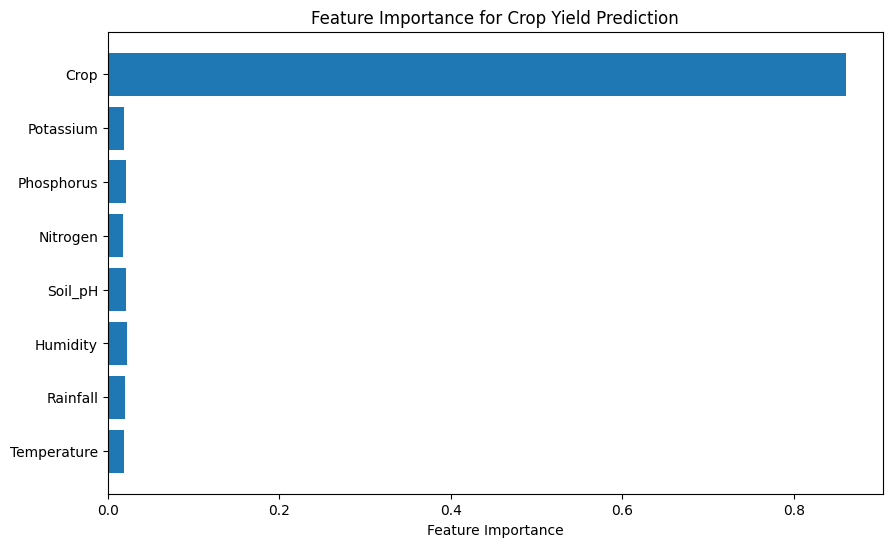

In [ ]:
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
feature_names = condition_features + ['Crop']
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Crop Yield Prediction")
plt.show()


In [5]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Crop Yields")
plt.show()


NameError: name 'plt' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Prediction on test set
y_pred = best_model.predict(X_test_final)

# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"📌 Mean Absolute Error (MAE): {mae:.2f} tons/ha")
print(f"📌 Mean Squared Error (MSE): {mse:.2f}")
print(f"📌 Root Mean Squared Error (RMSE): {rmse:.2f} tons/ha")
print(f"📌 R² Score: {r2:.2f}")

# Cross-validation (5-fold)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train_final, y_train, cv=kfold, scoring='r2')

print("\n📋 5-Fold Cross-Validation R² Scores:")
print(cv_scores)
print(f"📌 Mean CV R² Score: {cv_scores.mean():.2f}")
print(f"📌 Standard Deviation: {cv_scores.std():.2f}")


📌 Mean Absolute Error (MAE): 0.36 tons/ha
📌 Mean Squared Error (MSE): 0.20
📌 Root Mean Squared Error (RMSE): 0.44 tons/ha
📌 R² Score: 0.82

📋 5-Fold Cross-Validation R² Scores:
[0.82154346 0.82880321 0.81351265 0.83872248 0.84437326]
📌 Mean CV R² Score: 0.83
📌 Standard Deviation: 0.01
